In [1]:
import sys
import os

# Add the build directory to Python path
build_dir = os.path.abspath('/Users/kisel/uni/apal/Algorithm-Selector/Implementation/lib')
sys.path.insert(0, build_dir)

# Add the data directory to Python path
data_dir = os.path.abspath('/Users/kisel/uni/apal/Algorithm-Selector/Implementation/data')
sys.path.insert(0, data_dir)

import pandas as pd
import numpy as np
from tqdm import tqdm

import sorters
import probes
import time

import list_generators as lg
import runtime_features as rf
import create_features_dataset as cfd

In [2]:
df = pd.read_feather(data_dir+"/varied_dataset.feather")
data = df.tail(40_000)
data = cfd.create_features_dataset(data)

/Users/kisel/uni/apal/Algorithm-Selector/Implementation/lib/create_features_dataset.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['data'] = data['data'].apply(lambda arr: arr.tolist())
Extracting features: 100%|██████████| 40000/40000 [00:41<00:00, 952.70it/s]  
/Users/kisel/uni/apal/Algorithm-Selector/Implementation/lib/create_features_dataset.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['features'] = data['data'].progress_apply(rf.extract_features)
Benchmarking sorters: 100%|█████

In [3]:
data['best_sort'].value_counts()

best_sort
insertion_sort    14885
std_sort          13044
spin_sort          5657
quick_sort         4824
tim_sort           1066
merge_sort          524
Name: count, dtype: int64

In [4]:
feat_rows = []
for row in data['features']:
    feat_rows.append(row)

df = pd.DataFrame(feat_rows)
print(df)

        size  avg_dup_distinct    entropy   dis  mono  runs  categorical_skew  \
0        100               0.0   6.643856    71     9     9               0.0   
1        100               0.0   6.643856    67     9     9               0.0   
2        100               0.0   6.643856    35    10    10               0.0   
3        100               0.0   6.643856    76     9     9               0.0   
4        100               0.0   6.643856    82     9     9               0.0   
...      ...               ...        ...   ...   ...   ...               ...   
39995  10000               0.0  13.287712  9998  3183  5004               0.0   
39996  10000               0.0  13.287712  9998  3183  4972               0.0   
39997  10000               0.0  13.287712  9998  3183  4995               0.0   
39998  10000               0.0  13.287712  9998  3183  4985               0.0   
39999  10000               0.0  13.287712  9998  3183  5007               0.0   

       categorical_kurtosis

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from lightgbm import LGBMClassifier

# 1. Build X correctly
X = pd.DataFrame(data['features'].tolist()).fillna(0)

# 2. Inspect target balance
print(data['best_sort'].value_counts())

# 3. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, data['best_sort'], test_size=0.2, random_state=42
)

model = LGBMClassifier(
    n_estimators=300,
    learning_rate=0.02,
    random_state=42,
    class_weight='balanced'
)

# 5. Fit + Evaluate
model.fit(X_train, y_train)
print("Accuracy:", accuracy_score(y_test, model.predict(X_test)))

best_sort
insertion_sort    14885
std_sort          13044
spin_sort          5657
quick_sort         4824
tim_sort           1066
merge_sort          524
Name: count, dtype: int64
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001049 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1498
[LightGBM] [Info] Number of data points in the train set: 32000, number of used features: 8
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
Accuracy: 0.8095


In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Model with class_weight balanced
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    class_weight='balanced'  # Adjusts for class imbalance
)

# Train the model
rf_model.fit(X_train, y_train)

# Predict
y_pred = rf_model.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.827375
                precision    recall  f1-score   support

insertion_sort       0.94      0.96      0.95      2988
    merge_sort       0.09      0.12      0.11       107
    quick_sort       0.62      0.58      0.60       937
     spin_sort       0.71      0.80      0.75      1119
      std_sort       0.85      0.80      0.82      2634
      tim_sort       1.00      0.94      0.97       215

      accuracy                           0.83      8000
     macro avg       0.70      0.70      0.70      8000
  weighted avg       0.83      0.83      0.83      8000



In [7]:
def find_best_sorter(arr):
    best_name, best_time = None, float("inf")
    for sorter in sorters.list_sorters():
        time = sorters.benchmark_sorter(sorter, arr)
        if time < best_time:
            best_time, best_name = time, sorter

    return best_name

In [8]:
importances = rf_model.feature_importances_
features = X_train.columns

# Pair and sort
importance_list = sorted(zip(features, importances), key=lambda x: x[1], reverse=True)

print("\nFeature Importances:")
for feat, imp in importance_list:
    print(f"{feat:<25} {imp:.4f}")



Feature Importances:
mono                      0.3358
runs                      0.2953
dis                       0.1417
entropy                   0.0818
avg_dup_distinct          0.0508
categorical_skew          0.0355
size                      0.0323
categorical_kurtosis      0.0268


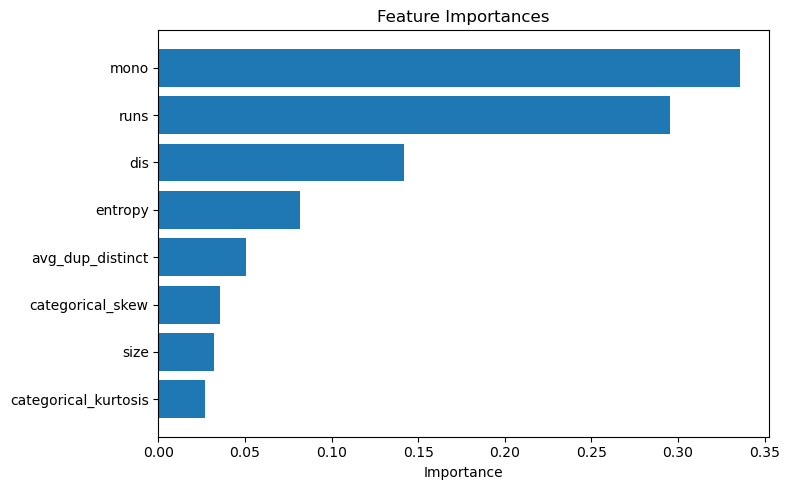

In [9]:
import matplotlib.pyplot as plt

# Plot top N features
top_n = 10
top_feats = importance_list[:top_n]
names, scores = zip(*top_feats)

plt.figure(figsize=(8, 5))
plt.barh(names[::-1], scores[::-1])
plt.xlabel("Importance")
plt.title(f"Feature Importances")
plt.tight_layout()
plt.show()

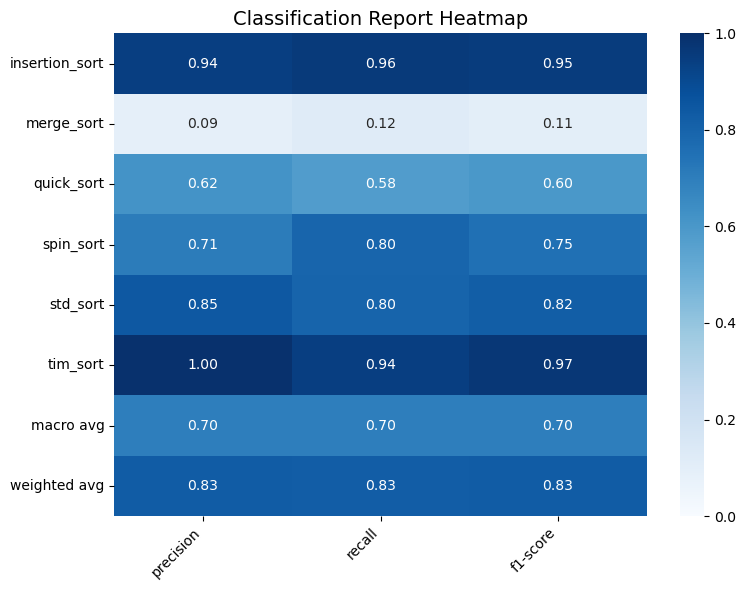

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

report_dict = classification_report(y_test, y_pred, output_dict=True)

df = pd.DataFrame(report_dict).transpose()

df.drop(index=['accuracy'], inplace=True, errors='ignore')
df.drop(columns=['support'], inplace=True, errors='ignore')

desired_order = ['precision', 'recall', 'f1-score']
df = df[[col for col in desired_order if col in df.columns]]

# --- Plotting ---
plt.figure(figsize=(8, 6))

sns.heatmap(
    df,
    annot=True,
    cmap='Blues',
    vmin=0.0,     # set lower bound for color scale
    vmax=1.0,     # set upper bound for color scale
    fmt=".2f",    # 2 decimal places in annotations
    cbar=True     # show color bar
)

plt.title("Classification Report Heatmap", fontsize=14)
plt.yticks(rotation=0)  # Keep class labels vertical
plt.xticks(rotation=45, ha='right')  # Rotate metric labels slightly
plt.tight_layout()
plt.show()

In [11]:
import joblib
joblib.dump(rf_model, 'rf_model.pkl')

['rf_model.pkl']